## **Data Analysis Project: Cinematic Business**  
**Quy trình:**  
- Giai đoạn 1: Làm sạch và khám phá dữ liệu
    + Customer data    
    + Ticket data  
    + Film data
        * listed_in, country: chuyển đổi cột chứa multi-value thành dummy value
        * duration: loại bỏ "min" và chuyển dữ liệu thành dạng int 
- Giai đoạn 2: Nạp dữ liệu
- Giai đoạn 3: Phân tích dữ liệu
    + Phân cụm khách hàng
        * Phân không ra cụm :v họp lại tí

In [240]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import random
import string
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')

## **Giai đoạn 1: Làm sạch dữ liệu**

### **Customer data**

In [241]:
data_url = 'https://github.com/anhvi02/ProjectCinema/raw/main/Data/DATA_SET_-_VONG_1_CUOC_THI_DATA_GOT_TALENT_2023.xlsx'
df_cust = pd.read_excel(data_url, sheet_name='customer')
df_cust.head(3)

,customerid,DOB,gender,address,Website,job,industry
0,0000000014,36268,Nữ,hoa khe quan thanh khe,KH0104|0345,student,computer
1,0000000034,35901,Nam,man thai,KH0104|0333,student,health service
2,0000000051,34319,Nam,que son quang nam,KH0104|0255,blue collar,economics


Khám phá dữ liệu

In [242]:
def explore_data(dataframe):
    print('Data Shape: \n ', dataframe.shape, end=' \n \n ')
    print('Data Types: \n ', dataframe.dtypes, end=' \n \n ')
    # print('Data information: \n ',dataframe.info(), end=' \n \n ')
    print('Data total missing values: \n ', dataframe.isnull().sum(), end=' \n \n ')
    print('Data total duplicated values: \n ',dataframe.duplicated().sum(), end=' \n \n ')

# explore_data(df_cust)

Xử lí dữ liệu thiếu:
- address: fill giá trị 'Unknown'  
- industry: fill giá trị 'Unemployed'

In [243]:
# Cột 'address': thay bằng 'unknown'
df_cust['address'] = df_cust['address'].fillna('Unknown')
df_cust

# Cột 'industry': thay bằng 'unemployed'
df_cust['industry'] = df_cust['industry'].fillna('Unemployed')
df_cust

,customerid,DOB,gender,address,Website,job,industry
0,0000000014,36268,Nữ,hoa khe quan thanh khe,KH0104|0345,student,computer
1,0000000034,35901,Nam,man thai,KH0104|0333,student,health service
2,0000000051,34319,Nam,que son quang nam,KH0104|0255,blue collar,economics
3,0000000081,36472,Nam,truong chinh,KH0104|0293,student,economics
4,0000000098,34608,Nam,cẩm lệ,KH0104|40580,blue collar,health service
...,...,...,...,...,...,...,...
4474,KH9855766,34885,Nữ,"A, THUAN PHUOC,HAI CHAU, DA NANG",NaN,specialist,finance
4475,KH9958204,36892,Nữ,"Phước Mỹ, ĐN",NaN,teenager,Unemployed
4476,WEBS00000043900,32311,Nữ,nguyen gian thanh,KHWEBS|00006890,specialist,construction
4477,WEBS00000044909,35316,Nữ,ngũ hành sơn,KHWEBS|00007899,blue collar,finance


Xử lí cột 'DOB':
- Chọn mốc thời gian là 01/01/1900
- Chuyển đổi những con số trong cột 'DOB' thành ngày cụ thể bằng timedelta

In [244]:
def convert_dob(data):
    data = int(data)
    
    # Chọn mốc thời gian (1 tháng 1 năm 1900)
    moc_tg = date(1900, 1, 1)

    # Chuyển đổi tổng số ngày thành ngày tháng năm cụ thể
    decoded_date = moc_tg + timedelta(days=data)

    return decoded_date

# Chuyển đổi giá trị số ngày thành ngày tháng và gán lại vào cột 'DOB'.
df_cust['DOB'] = df_cust['DOB'].apply(convert_dob)
df_cust.head(3)

,customerid,DOB,gender,address,Website,job,industry
0,0000000014,1999-04-20,Nữ,hoa khe quan thanh khe,KH0104|0345,student,computer
1,0000000034,1998-04-18,Nam,man thai,KH0104|0333,student,health service
2,0000000051,1993-12-18,Nam,que son quang nam,KH0104|0255,blue collar,economics


In [245]:
def extract_year(data):
    return data.year

df_cust['year'] = df_cust['DOB'].apply(extract_year)

obnormal_year = df_cust[(df_cust['year']>2024)  | (df_cust['year']<1900)]
obnormal_year

,customerid,DOB,gender,address,Website,job,industry,year
482,0000025876,2094-05-13,Nam,Nguyễn Xuân Nhĩ,NaN,teenager,Unemployed,2094
1177,0001013549,4352-05-11,Nam,ngũ hành sơn,KH0104|24922,teenager,Unemployed,4352
1563,0001077023,7980-09-02,Nam,bành thái bưởi Hòa khánh liên chiểu,KH0104|27958,teenager,Unemployed,7980
2207,0001120656,9997-11-23,Nam,quận ngũ hành sơn,KH0104|46001,teenager,Unemployed,9997


In [246]:
mode_year = df_cust['year'].mode()

for ind in obnormal_year.index:
    df_cust.iloc[ind, 1] = df_cust.iloc[ind, 1].replace(year=mode_year)
df_cust[(df_cust['year']>2024)  | (df_cust['year']<1900)]

,customerid,DOB,gender,address,Website,job,industry,year
482,0000025876,1999-05-13,Nam,Nguyễn Xuân Nhĩ,NaN,teenager,Unemployed,2094
1177,0001013549,1999-05-11,Nam,ngũ hành sơn,KH0104|24922,teenager,Unemployed,4352
1563,0001077023,1999-09-02,Nam,bành thái bưởi Hòa khánh liên chiểu,KH0104|27958,teenager,Unemployed,7980
2207,0001120656,1999-11-23,Nam,quận ngũ hành sơn,KH0104|46001,teenager,Unemployed,9997


In [247]:
df_cust = df_cust.drop(columns='year')
df_cust.head(3)

,customerid,DOB,gender,address,Website,job,industry
0,0000000014,1999-04-20,Nữ,hoa khe quan thanh khe,KH0104|0345,student,computer
1,0000000034,1998-04-18,Nam,man thai,KH0104|0333,student,health service
2,0000000051,1993-12-18,Nam,que son quang nam,KH0104|0255,blue collar,economics


### **Ticket data**

In [248]:
data_url = 'https://github.com/anhvi02/ProjectCinema/raw/main/Data/DATA_SET_-_VONG_1_CUOC_THI_DATA_GOT_TALENT_2023.xlsx'
df_tick = pd.read_excel(data_url, sheet_name='ticket')
df_tick.head()

,orderid,cashier,saledate,total,customerid,ticketcode,date,time,slot,room,film,slot type,ticket type,ticket price,popcorn
0,10006052019B0225,emp002,2019-05-06 16:40:43,90000.0,0000000014,20074925,2019-05-06,18:15:00,G04,3,AVENGERS: HỒI KẾT,ĐƠN,Thành viên,45000,Không
1,10006052019B0225,emp002,2019-05-06 16:40:43,90000.0,0000000014,20074924,2019-05-06,18:15:00,G03,3,AVENGERS: HỒI KẾT,ĐƠN,Thành viên,45000,Không
2,10022052019B0167,emp011,2019-05-22 20:30:28,90000.0,0000000034,20097042,2019-05-22,20:45:00,E04,2,JOHN WICK 3: CHUẨN BỊ CHIẾN TRANH (C18),ĐƠN,Thành viên,45000,Không
3,10022052019B0167,emp011,2019-05-22 20:30:28,90000.0,0000000034,20097041,2019-05-22,20:45:00,E03,2,JOHN WICK 3: CHUẨN BỊ CHIẾN TRANH (C18),ĐƠN,Thành viên,45000,Không
4,10130052019B0141,emp005,2019-05-30 19:28:44,90000.0,0000000034,20106761,2019-05-30,19:30:00,F04,1,NGÔI ĐỀN KỲ QUÁI (C18),ĐƠN,Thành viên,45000,Không


In [249]:
explore_data(df_tick)

Data Shape: 
  (35474, 15) 
 
 Data Types: 
  orderid                 object
cashier                 object
saledate        datetime64[ns]
total                  float64
customerid              object
ticketcode               int64
date            datetime64[ns]
time                    object
slot                    object
room                     int64
film                    object
slot type               object
ticket type             object
ticket price             int64
popcorn                 object
dtype: object 
 
 Data total missing values: 
  orderid         96
cashier          0
saledate        96
total           96
customerid       0
ticketcode       0
date             0
time             0
slot             0
room             0
film             0
slot type        0
ticket type      0
ticket price     0
popcorn         96
dtype: int64 
 
 Data total duplicated values: 
  0 
 
 

Gộp 2 cột date, time thành 1 cột 

In [250]:
# chuyển cột time thành dạng showtime
df_tick['time'] = pd.to_datetime(df_tick['time'], format='%H:%M:%S')
# trích xuất time dạng HH:MM:SS thành str
df_tick['time'] = df_tick['time'].dt.strftime('%H:%M:%S')
# Chuyển cột date thành str để + với time
df_tick['date']=df_tick['date'].astype(str)
df_tick['showtime'] = pd.to_datetime(df_tick['date'] + ' ' + df_tick['time'])
# drop cột date và time
df_tick.drop(columns=['date','time'],inplace = True)

Fill null cho cột total

In [251]:
df_total_null = df_tick[df_tick['total'].isnull()]
df_total_null.head()

,orderid,cashier,saledate,total,customerid,ticketcode,slot,room,film,slot type,ticket type,ticket price,popcorn,showtime
23,NaN,Website,NaT,NaN,0000000228,20100926,G09,3,ALADDIN (PD) (G),ĐƠN,Thành viên,45000,NaN,2019-05-25 19:45:00
24,NaN,Website,NaT,NaN,0000000228,20100927,G10,3,ALADDIN (PD) (G),ĐƠN,Thành viên,45000,NaN,2019-05-25 19:45:00
580,NaN,Website,NaT,NaN,0000011318,20092413,G09,1,POKÉMON: THÁM TỬ PIKACHU (C13),ĐƠN,Thành viên,45000,NaN,2019-05-18 18:40:00
581,NaN,Website,NaT,NaN,0000011318,20092412,G08,1,POKÉMON: THÁM TỬ PIKACHU (C13),ĐƠN,Thành viên,45000,NaN,2019-05-18 18:40:00
582,NaN,Website,NaT,NaN,0000011318,20092411,G07,1,POKÉMON: THÁM TỬ PIKACHU (C13),ĐƠN,Thành viên,45000,NaN,2019-05-18 18:40:00


In [252]:
df_total_price = df_total_null.groupby(['customerid', 'showtime']).agg(total_ticket_price=('ticket price', 'sum')).reset_index()
# result_df = grouped_df.size().reset_index(name='count')
# result_df
df_total_price.head(3)

,customerid,showtime,total_ticket_price
0,0000000228,2019-05-25 19:45:00,90000
1,0000011318,2019-05-18 18:40:00,135000
2,0000012411,2019-05-26 19:35:00,90000


In [253]:
merged_df = pd.merge(df_total_null, df_total_price, on=['customerid', 'showtime'], how='left')
merged_df['total'] = merged_df['total_ticket_price'].combine_first(merged_df['total'])
merged_df = merged_df.drop(columns=['total_ticket_price'])
merged_df[merged_df['customerid'] == '0001122293']

,orderid,cashier,saledate,total,customerid,ticketcode,slot,room,film,slot type,ticket type,ticket price,popcorn,showtime
51,NaN,Website,NaT,45000,0001122293,20091894,G10,3,JOHN WICK 3: CHUẨN BỊ CHIẾN TRANH (C18),ĐƠN,Thành viên,45000,NaN,2019-05-18 15:00:00
52,NaN,Website,NaT,180000,0001122293,20104758,G09,3,ALADDIN (PD) (G),ĐƠN,Thành viên,45000,NaN,2019-05-28 19:50:00
53,NaN,Website,NaT,180000,0001122293,20104760,G11,3,ALADDIN (PD) (G),ĐƠN,Thành viên,45000,NaN,2019-05-28 19:50:00
54,NaN,Website,NaT,180000,0001122293,20104759,G10,3,ALADDIN (PD) (G),ĐƠN,Thành viên,45000,NaN,2019-05-28 19:50:00
55,NaN,Website,NaT,180000,0001122293,20104757,G08,3,ALADDIN (PD) (G),ĐƠN,Thành viên,45000,NaN,2019-05-28 19:50:00


Fill null cho order id

In [254]:
# Groupby theo cột customerid và datetime, sau đó sử dụng transform để fill giá trị null trong cột orderid
grouped_df = merged_df.groupby(['customerid', 'showtime'])
df_fill_orderid = grouped_df.size().reset_index(name='count')
# tách ngày tháng năm trong cột datetime
df_fill_orderid['formatted_date'] = df_fill_orderid['showtime'].dt.strftime('%d%m%Y')
# def hàm sinh ra các chữ cái cuối của orderid 
def generate_random_string():
    # Chọn một chữ cái ngẫu nhiên viết hoa
    first_letter = random.choice(string.ascii_uppercase)
    
    # Chọn 4 chữ số ngẫu nhiên
    digits = ''.join(random.choices(string.digits, k=4))
    
    # Kết hợp chữ cái và chữ số để tạo chuỗi hoàn chỉnh
    random_string = first_letter + digits
    
    return random_string

list_random_orderid = []

for ele in range(len(df_fill_orderid)):
    five_last_character = generate_random_string()
    # fill order id
    random_id = '102'+ df_fill_orderid.iloc[ele,-1] + five_last_character
    list_random_orderid.append(random_id)
    
df_fill_orderid['order_id'] = list_random_orderid
df_fill_orderid.head(3)

,customerid,showtime,count,formatted_date,order_id
0,0000000228,2019-05-25 19:45:00,2,25052019,10225052019B8292
1,0000011318,2019-05-18 18:40:00,3,18052019,10218052019X0675
2,0000012411,2019-05-26 19:35:00,2,26052019,10226052019P3021


Data sau khi fillnull

In [255]:
# merge dataframe sau khi đã fill null cho total và orderid
df_after_fill = pd.merge(merged_df, df_fill_orderid, on=['customerid', 'showtime'], how='left')
df_after_fill['orderid'] = df_after_fill['order_id'].combine_first(df_after_fill['order_id'])
df_after_fill = df_after_fill.drop(columns=['order_id','count','formatted_date'])
# drop null bảng ticket
df_tick=df_tick.dropna()
df_tick = pd.concat([df_tick, df_after_fill], ignore_index=True)

In [256]:
df_tick['total'] = df_tick['total'].astype(int)

In [257]:
explore_data(df_tick)

Data Shape: 
  (35474, 14) 
 
 Data Types: 
  orderid                 object
cashier                 object
saledate        datetime64[ns]
total                    int64
customerid              object
ticketcode               int64
slot                    object
room                     int64
film                    object
slot type               object
ticket type             object
ticket price             int64
popcorn                 object
showtime        datetime64[ns]
dtype: object 
 
 Data total missing values: 
  orderid          0
cashier          0
saledate        96
total            0
customerid       0
ticketcode       0
slot             0
room             0
film             0
slot type        0
ticket type      0
ticket price     0
popcorn         96
showtime         0
dtype: int64 
 
 Data total duplicated values: 
  0 
 
 

### **Film data**

In [258]:
data_url = 'https://github.com/anhvi02/ProjectCinema/raw/main/Data/DATA_SET_-_VONG_1_CUOC_THI_DATA_GOT_TALENT_2023.xlsx'
df_film = pd.read_excel(data_url, sheet_name='film')
df_film.head(3)

,show_id,title,director,cast,country,release_year,rating,duration,listed_in,description
0,s27,X-Men: Dark Phoenix,Simon Kinberg,"James McAvoy, Michael Fassbender, Jennifer Law...","United States, Canada",2019,PG-13,115 min,"Action-Adventure, Family, Science Fiction",When Jean Grey transforms into the Dark Phoeni...
1,s165,The Kid Who Would Be King,Joe Cornish,"Louis Ashbourne Serkis, Tom Taylor, Rebecca Fe...","United Kingdom, United States",2019,PG,121 min,"Action-Adventure, Coming of Age, Family","When a kid discovers the legendary sword, Exca..."
2,s194,Disney My Music Story: Perfume,Kentaro Takayanagi,"a-chan , KASHIYUKA , NOCCHi",NaN,2019,NaN,53 min,"Biographical, Documentary, Music",J-Pop band Perfume shares their passion for mu...


Khám phá dữ liệu

In [259]:
# kiểm tra nếu cột show_id có giá trị lặp
df_film['show_id'].duplicated().sum()

0

In [260]:
def explore_data(dataframe):
    print('Data Shape: \n ', dataframe.shape, end=' \n \n ')
    print('Data Types: \n ', dataframe.dtypes, end=' \n \n ')
    # print('Data information: \n ',dataframe.info(), end=' \n \n ')
    print('Data total missing values: \n ', dataframe.isnull().sum(), end=' \n \n ')
    print('Data total duplicated values: \n ',dataframe.duplicated().sum(), end=' \n \n ')

explore_data(df_film)

Data Shape: 
  (60, 10) 
 
 Data Types: 
  show_id         object
title           object
director        object
cast            object
country         object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object 
 
 Data total missing values: 
  show_id          0
title            0
director        10
cast             6
country          7
release_year     0
rating           1
duration         0
listed_in        0
description      0
dtype: int64 
 
 Data total duplicated values: 
  0 
 
 

Xử lí giá trị thiếu:  
    - rating: fill giá trị mode

In [261]:
mode_value = df_film['rating'].mode()
print('Mode của cột rating:', mode_value)

# fill na cho cột rating
df_film['rating'].fillna(mode_value, inplace=True)

Mode của cột rating: 0    TV-PG
Name: rating, dtype: object


Chuyển đổi dữ liệu:
- listed_in: chuyển đổi từ multi-value thành dummy value 
- country: chuyển đổi từ multi-value thành dummy value 
- duration: loại bỏ 'min' khỏi data và chuyển data từ dạng object thành int

In [262]:
# define các function phục vụ chuyển đổi multil-value column

# hàm tính toán số lượng unique value trong cột multi-value
def unique_cnt(series, seperator):
    unique_cnt = {}
    for ele in series:
        list_values = ele.split(seperator)
        # remove blank space 
        list_values = [item.replace(' ', '') for item in list_values]
        for typ in list_values:
            if typ not in unique_cnt:
                unique_cnt[typ] = 1
            else:
                unique_cnt[typ] += 1
    unique_cnt = sorted(unique_cnt.items(), key=lambda x: x[1], reverse=True)
    return unique_cnt


# hàm chuyển đổi từ multi-value column thành dummy-value columns
def multi_to_dummy(dataframe, column, pref=None, seperator=','):
    # convert into list type data
    split_col = dataframe[column].str.split(seperator)
    # get dummy and group
    df_dummy = pd.get_dummies(split_col.apply(pd.Series).stack(), prefix=pref).sum(level= 0)
    return df_dummy 

In [263]:
# số lượng unique value trong cột listed_in
unique_cnt(df_film['listed_in'], ',')

[('Family', 29),
 ('Documentary', 24),
 ('Action-Adventure', 21),
 ('Animation', 21),
 ('Comedy', 15),
 ('Historical', 9),
 ('Fantasy', 9),
 ('ComingofAge', 8),
 ('Animals&Nature', 6),
 ('ScienceFiction', 4),
 ('Superhero', 3),
 ('Biographical', 2),
 ('Music', 2),
 ('Drama', 2),
 ('Buddy', 2),
 ('Musical', 1),
 ('ConcertFilm', 1),
 ('Dance', 1)]

Vì số lượng unique value không quá lớn nên việc tách thành dummy value sẽ không sinh quá nhiều cột mới, do đó nhóm quyết định thực hiện tách thành dummy value

In [264]:
# dummy_data = multi_to_dummy(df_film,'listed_in', pref='genre', seperator=',')
# df_film = pd.concat([df_film, dummy_data], axis=1).drop(columns=['listed_in'])
# df_film.head(3)

In [265]:
# # tạm thời fill null cho cột country với "Unknown"
# df_film['country'].fillna("Unknown", inplace=True)
# # số lượng unique value trong cột country
# unique_cnt(df_film['country'], ',')

In [266]:
# dummy_data = multi_to_dummy(df_film,'country', pref='country', seperator=',')
# df_film = pd.concat([df_film, dummy_data], axis=1).drop(columns=['country', 'country_Unknown'])
# df_film.head(3)

In [267]:
# # loại bỏ 'min' khỏi cột duration và chuyển về datatype int
# df_film['duration'] = df_film['duration'].str.replace(' min', '').astype(int)
# df_film.head(3)

Phân tích tương quan

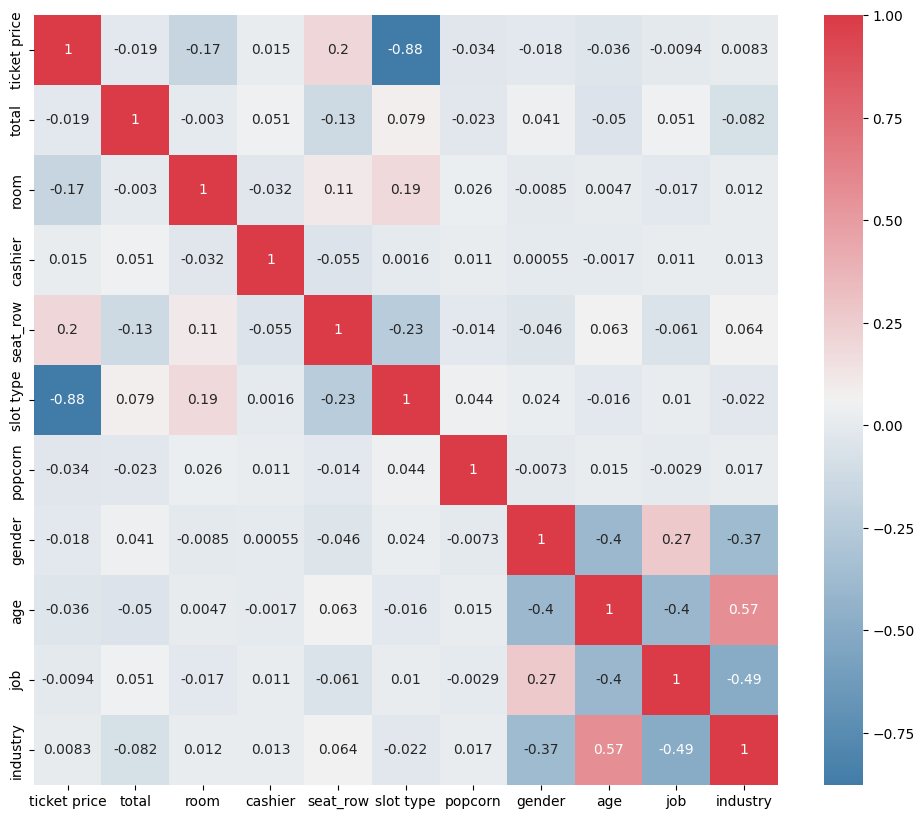

In [268]:
import datetime as dt

df_corr = df_tick.copy()
def extract_seatrow(data):
    return data[:1]

# extract seat_row
df_corr['seat_row'] = df_corr['slot'].apply(extract_seatrow)

df_merged = pd.merge(df_corr, df_cust, on=['customerid'], how='left')
df_merged = df_merged.dropna(subset='popcorn')

# extract age
def extract_age(birthday):
    today = datetime.now().year
    age = today - birthday.year
    return age
df_merged['age'] = df_merged['DOB'].apply(extract_age)

# encode categorical columns
list_columns_encode = ['cashier','seat_row','slot type','ticket type','popcorn','gender','job','industry']
    
from sklearn.preprocessing import LabelEncoder
for col in list_columns_encode:
    enc = LabelEncoder()
    df_merged[col] = enc.fit_transform(df_merged[col])

# calculate calculation
list_columns_corr = ['ticket price', 'total','room', 'cashier','seat_row','slot type','popcorn','gender','age', 'job','industry']

# pearson correlation
corr = df_merged[list_columns_corr].corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# plotting
plt.figure(figsize=(12,10))
sns.heatmap(data=corr,annot=True, cmap=cmap)
plt.show()
# df_merged.head(10)

## **Giai đoạn 1.5: Load Data**

**Login database**

In [269]:
import pyodbc
import streamlit as st
import pandas as pd

# Connection details
server = 'projectcinemaserver.database.windows.net'
database = 'cinemadatabase'
username = 'datasquad'
password = 'Homies@2024'
driver = '{ODBC Driver 18 for SQL Server}' 
encoding = 'utf-8'

# Connection string with character encoding specified
conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};CHARSET={encoding}'

# Connect to the database
conn = pyodbc.connect(conn_str)


**Cấu hình table database bao gồm 3 table:**
- Customer  
- Film  
- Ticker

In [270]:
# # Cursor
# cursor = conn.cursor()

# # SQL command to create Ticket table
# create_ticket_table = """
# CREATE TABLE Ticket (
#     orderid NVARCHAR(50),
#     cashier NVARCHAR(50),
#     saledate datetime NULL,
#     total int,
#     customerid NVARCHAR(50), 
#     ticketcode NVARCHAR(50),
#     slot NVARCHAR(50),
#     room tinyint,
#     film NVARCHAR(100),
#     slot_type NVARCHAR(50),
#     ticket_type NVARCHAR(50),
#     ticket_price int,
#     popcorn NVARCHAR(50) NULL,
#     showtime datetime,
# )
# """
# cursor.execute(create_ticket_table)

# # SQL command to create Customer table
# create_customer_table = """
# CREATE TABLE Customer (
#     customerid NVARCHAR(50) PRIMARY KEY,
#     DOB date NULL,
#     gender NVARCHAR(10) NULL,
#     Website NVARCHAR(50) NULL,
#     address NVARCHAR(MAX) NULL,
#     job NVARCHAR(50) NULL,
#     industry NVARCHAR(50) NULL,
# )
# """
# cursor.execute(create_customer_table)


# # SQL command to create Film table
# create_film_table = """
# CREATE TABLE Film (
#     show_id NVARCHAR(50) PRIMARY KEY,
#     title NVARCHAR(100),
#     director NVARCHAR(50) NULL,
#     cast NVARCHAR(200) NULL,
#     country NVARCHAR(50) NULL,
#     release_year int NULL,
#     rating NVARCHAR(50) NULL,
#     duration NVARCHAR(50) NULL,
#     listed_in NVARCHAR(50) NULL,
#     description NVARCHAR(200) NULL,
# )
# """
# cursor.execute(create_film_table)

# SQL command to create contraints
# customerid
# create_contraint_customerid = """
# ALTER TABLE Ticket
#     ADD CONSTRAINT FK_Ticket_Customer
#     FOREIGN KEY (customerid) 
#     REFERENCES Customer(customerid);
# """

# # # film title
# create_contraint_filmtitle = """
# ALTER TABLE Ticket
#     ADD CONSTRAINT FK_Ticket_Film
#     FOREIGN KEY (film) 
#     REFERENCES Film(title);
# """
# # Commit the transaction
# conn.commit()

# # Close the connection
# # conn.close()

**Nạp dữ liệu sau khi được xử lý**

Bảng Customer

In [271]:
# # Cursor
# cursor = conn.cursor()

# insert_query = """
# INSERT INTO Customer (customerid, DOB, gender, address, Website, job, industry)
# VALUES (?, ?, ?, ?, ?, ?, ?)
# """

# # Iterate over rows in the DataFrame
# for index, row in df_cust.iloc[:100,:].iterrows():
#     # Replace NaN values with None in the row
#     row = row.where(pd.notnull(row), None)
    
#     # Check if the customerid already exists in the table
#     cursor.execute("SELECT COUNT(*) FROM Customer WHERE customerid = ?", row['customerid'])
#     if cursor.fetchone()[0] > 0:
#         print(f"Customer id number: {row['customerid']} is already in the table")
#     else:
#         # Execute the insert query with parameters from the current row
#         cursor.execute(insert_query, tuple(row))
#         conn.commit()

Bảng Film

In [272]:
# # Cursor
# cursor = conn.cursor()

# insert_query = """
# INSERT INTO Film (show_id, title, director, cast, country, release_year, rating, duration, listed_in, description)
# VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
# """

# # Iterate over rows in the DataFrame
# for index, row in df_film.iloc[:100,:].iterrows():
#     # Replace NaN values with None in the row
#     row = row.where(pd.notnull(row), None)
    
#     # Check if the film title already exists in the table
#     cursor.execute("SELECT COUNT(*) FROM Film WHERE title = ?", row['title'])
#     if cursor.fetchone()[0] > 0:
#         print(f"Film title: {row['title']} is already in the table")
#     else:
#         # Execute the insert query with parameters from the current row
#         cursor.execute(insert_query, tuple(row))
#         conn.commit()


Bảng Ticket

In [273]:
# # Cursor
# cursor = conn.cursor()

# insert_query = """
# INSERT INTO Ticket (orderid, cashier, saledate, total, customerid, ticketcode, slot, room, film, slot_type, ticket_type, ticket_price, popcorn, showtime)
# VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
# """

# # Iterate over rows in the DataFrame
# for index, row in df_tick.iloc[:100,:].iterrows():
#     # Replace NaN values with None in the row
#     row = row.where(pd.notnull(row), None)
    
#     # Check if the ticket already exists in the table
#     cursor.execute("""
#         SELECT COUNT(*) 
#         FROM Ticket 
#         WHERE orderid = ? AND cashier = ? AND saledate = ? AND total = ? AND customerid = ? 
#         AND ticketcode = ? AND slot = ? AND room = ? AND film = ? AND slot_type = ? 
#         AND ticket_type = ? AND ticket_price = ? AND popcorn = ? AND showtime = ?
#     """, tuple(row))
    
#     if cursor.fetchone()[0] > 0:
#         print("Ticket already exists:", tuple(row))
#     else:
#         # Execute the insert query with parameters from the current row
#         cursor.execute(insert_query, tuple(row))
#         conn.commit()


In [274]:
conn.close()

## **Giai đoạn 2: Phân tích dữ liệu**

### **Sale Analysis**

**Tổng doanh thu**

In [275]:
df_order = df_tick.drop_duplicates(subset=['orderid'])
df_order.head(3)

,orderid,cashier,saledate,total,customerid,ticketcode,slot,room,film,slot type,ticket type,ticket price,popcorn,showtime
0,10006052019B0225,emp002,2019-05-06 16:40:43,90000,0000000014,20074925,G04,3,AVENGERS: HỒI KẾT,ĐƠN,Thành viên,45000,Không,2019-05-06 18:15:00
2,10022052019B0167,emp011,2019-05-22 20:30:28,90000,0000000034,20097042,E04,2,JOHN WICK 3: CHUẨN BỊ CHIẾN TRANH (C18),ĐƠN,Thành viên,45000,Không,2019-05-22 20:45:00
4,10130052019B0141,emp005,2019-05-30 19:28:44,90000,0000000034,20106761,F04,1,NGÔI ĐỀN KỲ QUÁI (C18),ĐƠN,Thành viên,45000,Không,2019-05-30 19:30:00


In [276]:
total_sale = round(df_order['total'].sum())
print('Tổng doanh thu:', total_sale)
# df_tick['orderid'].duplicated().sum()

Tổng doanh thu: 1686815000


**Số lượng order**

In [277]:
print('Tổng số order:',len(df_order['orderid']))

Tổng số order: 14641


In [278]:
print('Tổng số vé:',len(df_tick['orderid']))

Tổng số vé: 35474


*Số lượng phim được chiếu

In [279]:
len(df_order['film'].unique())

19

**Doanh thu theo các giờ trong ngày**

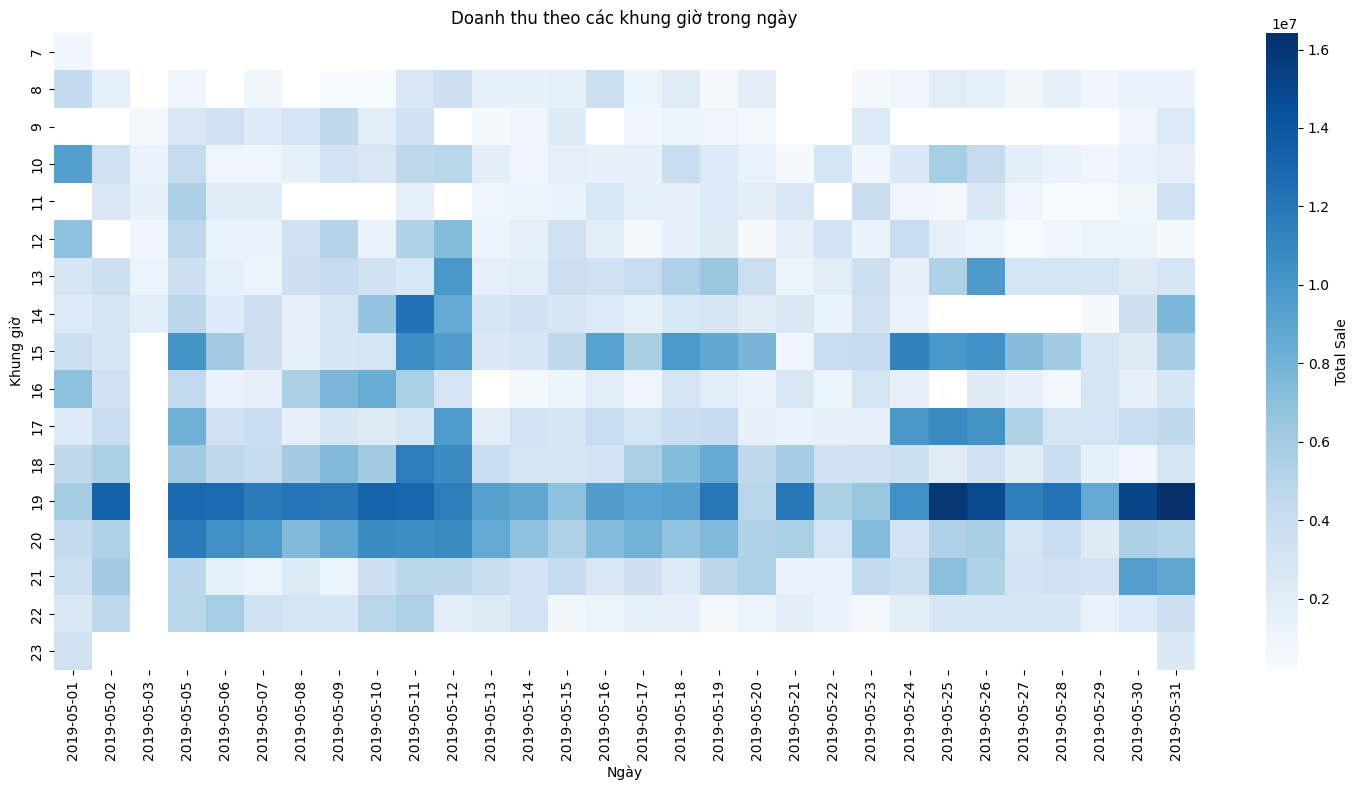

In [280]:
# Assuming your DataFrame is named 'df_sale_time' with columns 'showtime' and 'total'
# Convert 'showtime' to datetime format
df_sale_time = df_order.copy()
df_sale_time['showtime'] = pd.to_datetime(df_sale_time['showtime'])

# Extract date and hour from 'showtime'
df_sale_time['date'] = df_sale_time['showtime'].dt.date
df_sale_time['hour'] = df_sale_time['showtime'].dt.hour

# Create a pivot table
hourly_sales_pivot = df_sale_time.pivot_table(values='total', index='hour', columns='date', aggfunc='sum')

# Plotting with Seaborn
plt.figure(figsize=(15, 8))
sns.heatmap(hourly_sales_pivot, cmap='Blues', cbar_kws={'label': 'Total Sale'})
2
plt.title('Doanh thu theo các khung giờ trong ngày')
plt.xlabel('Ngày')
plt.ylabel('Khung giờ')
plt.tight_layout()

plt.show()

*Nhận xét:*
- Khung giờ 15h và 19h, 20h có doanh thu cao hơn hẳn so với những khung giờ khác trong ngày  
- Doanh thu trong hai khoảng thời gian từ ngày 10-ngày 12 và từ ngày 24-ngày 26 cao đột biến  
    - Ngày 10/5 và 24/5 là thứ 6 bắt đầu chuỗi 3 ngày cuối tuần
    - Nguyên nhân có thể do có sự ra mắt của một số phim như:
        - POKÉMON: THÁM TỬ PIKACHU (C13) (ra mắt từ ngày 10)
        - NGÔI ĐỀN KỲ QUÁI (C18) (ra mắt từ ngày 24)
        - ALADDIN (PD) (G) (ra mắt từ ngày 24)  
        

In [281]:
print('Ngày ra mắt phim POKÉMON: THÁM TỬ PIKACHU (C13)')
df_sale_time['date']=pd.to_datetime(df_sale_time['date'])
print(df_sale_time[df_sale_time['film'] == 'POKÉMON: THÁM TỬ PIKACHU (C13)'].sort_values(by='date').head(1)['date'])
print()
print('Ngày ra mắt phim NGÔI ĐỀN KỲ QUÁI (C18)')
df_sale_time['date']=pd.to_datetime(df_sale_time['date'])
print(df_sale_time[df_sale_time['film'] == 'NGÔI ĐỀN KỲ QUÁI (C18)'].sort_values(by='date').head(1)['date'])
print()
print('Ngày ra mắt phim ALADDIN (PD) (G)')
df_sale_time['date']=pd.to_datetime(df_sale_time['date'])
print(df_sale_time[df_sale_time['film'] == 'ALADDIN (PD) (G)'].sort_values(by='date').head(1)['date'])

Ngày ra mắt phim POKÉMON: THÁM TỬ PIKACHU (C13)
46   2019-05-10
Name: date, dtype: datetime64[ns]

Ngày ra mắt phim NGÔI ĐỀN KỲ QUÁI (C18)
7412   2019-05-24
Name: date, dtype: datetime64[ns]

Ngày ra mắt phim ALADDIN (PD) (G)
7432   2019-05-24
Name: date, dtype: datetime64[ns]


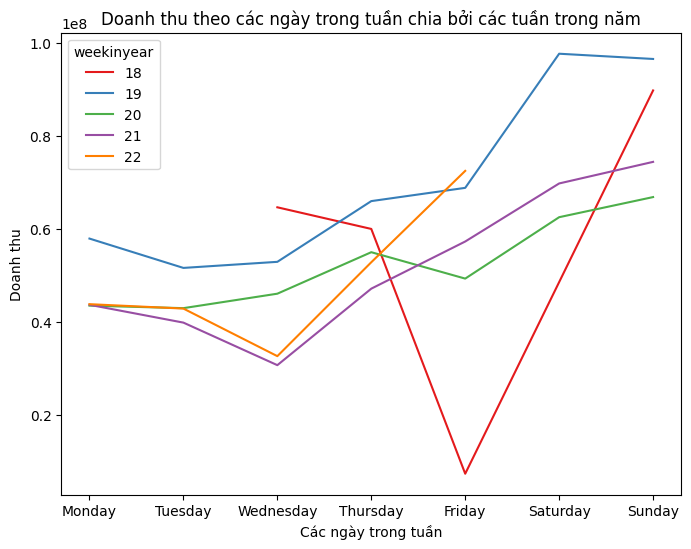

In [282]:

df_sale_time = df_order.copy()
df_sale_time['showtime'] = pd.to_datetime(df_sale_time['showtime'])


week = []
# Extract date and hour from 'showtime'
for ele in  df_sale_time['showtime']:
    week.append(ele.isocalendar()[1])
df_sale_time['dayinweek'] = df_sale_time['showtime'].dt.day_name()
df_sale_time['weekinyear'] = week

sale_by_dayinweek = pd.DataFrame(df_sale_time.groupby(['dayinweek','weekinyear'])['total'].sum()).reset_index()
# Mapping days of the week to numbers
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

sale_by_dayinweek['numbered_dayinweek']=sale_by_dayinweek['dayinweek'].map(day_mapping)
sale_by_dayinweek  = sale_by_dayinweek.sort_values(by='numbered_dayinweek')
sale_by_dayinweek.head(3)

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(data=sale_by_dayinweek, x='dayinweek', y='total', hue='weekinyear', palette='Set1')
plt.title('Doanh thu theo các ngày trong tuần chia bởi các tuần trong năm')
plt.xlabel('Các ngày trong tuần')
plt.ylabel('Doanh thu')
plt.show()


- Phân tích:
    + Chủ Nhật (Sunday): Có tổng doanh thu cao nhất. Điều này có thể do ngày Chủ nhật thường là ngày nghỉ cuối tuần và nhiều người có thêm thời gian để mua sắm hoặc tiêu dùng.
    + Thứ Năm (Thursday): Doanh thu vào ngày này khá cao, đứng thứ ba. Có thể có những chương trình khuyến mãi hoặc sự kiện đặc biệt vào ngày này trong tuần.

**Doanh thu của phim trong tháng**

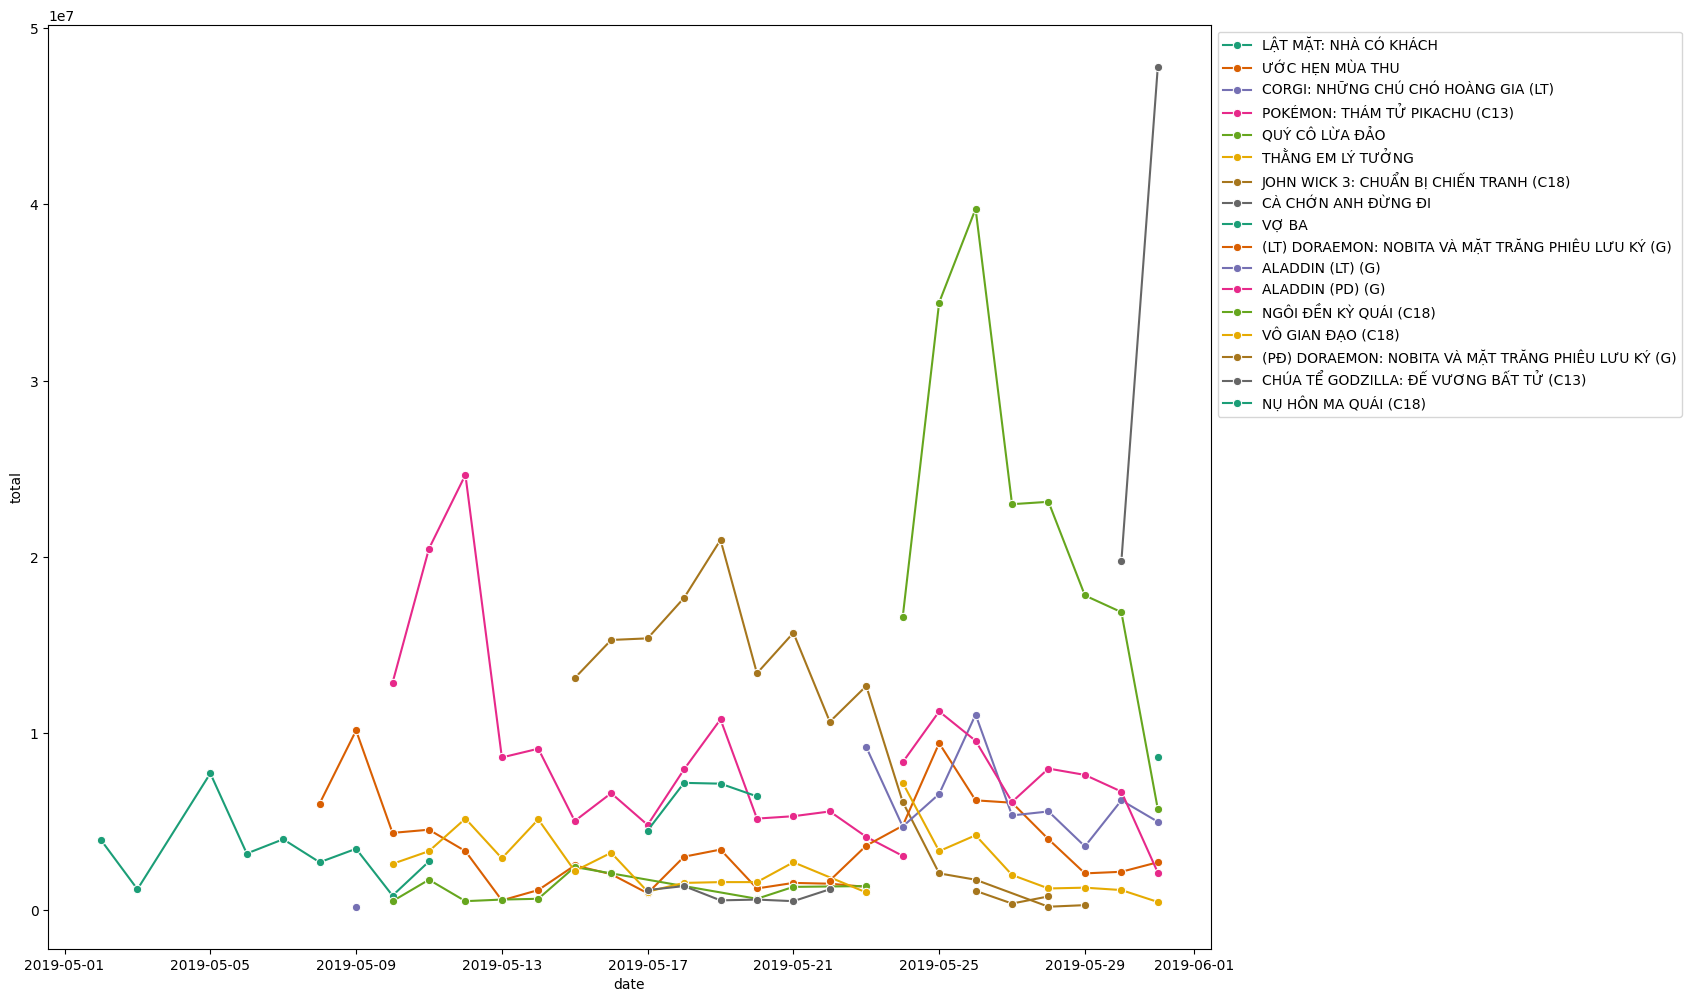

In [283]:
df_sale_film = df_order.copy()
df_sale_film['showtime'] = pd.to_datetime(df_sale_film['showtime'])

# Extract date and hour from 'showtime'
df_sale_film['date'] = df_sale_film['showtime'].dt.date
gr_sale_film = pd.DataFrame(df_sale_film.groupby(['date','film'])['total'].sum()).reset_index()

# check if movie is released before May
films_to_drop = list(gr_sale_film[gr_sale_film['date'].astype(str) == '2019-05-01']['film'].values)
gr_sale_film = gr_sale_film[~gr_sale_film['film'].isin(films_to_drop)]
# Plot the line plot
fig, ax = plt.subplots(figsize=(15,12))
ax = sns.lineplot(data=gr_sale_film, x='date', y='total', hue='film', palette='Dark2', marker='o')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

**Doanh thu theo thời gian bởi nghề nghiệp**


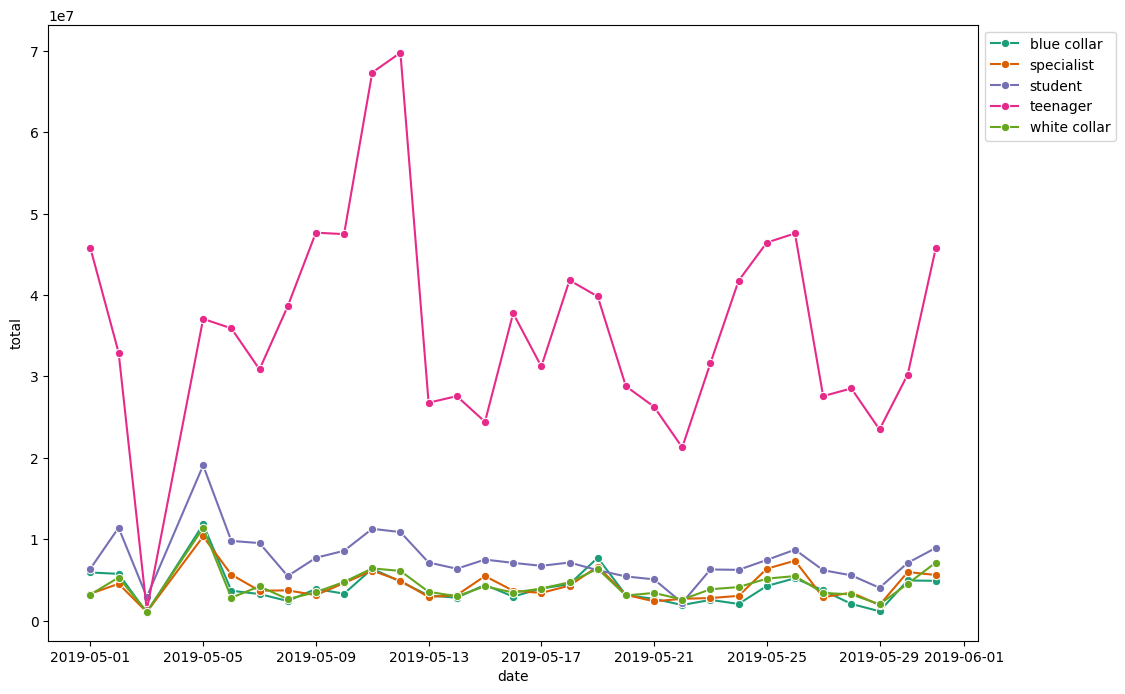

In [284]:
df_sale_job = df_order.copy()
df_sale_job = pd.merge(df_sale_job, df_cust, how='left', on='customerid')
df_sale_job['showtime'] = pd.to_datetime(df_sale_job['showtime'])

# Extract date and hour from 'showtime'
df_sale_job['date'] = df_sale_job['showtime'].dt.date
gr_sale_film = pd.DataFrame(df_sale_job.groupby(['date','job'])['total'].sum()).reset_index()

# Plot the line plot
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(data=gr_sale_film, x='date', y='total', hue='job', palette='Dark2', marker='o')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

**Doanh thu theo hàng ghế**

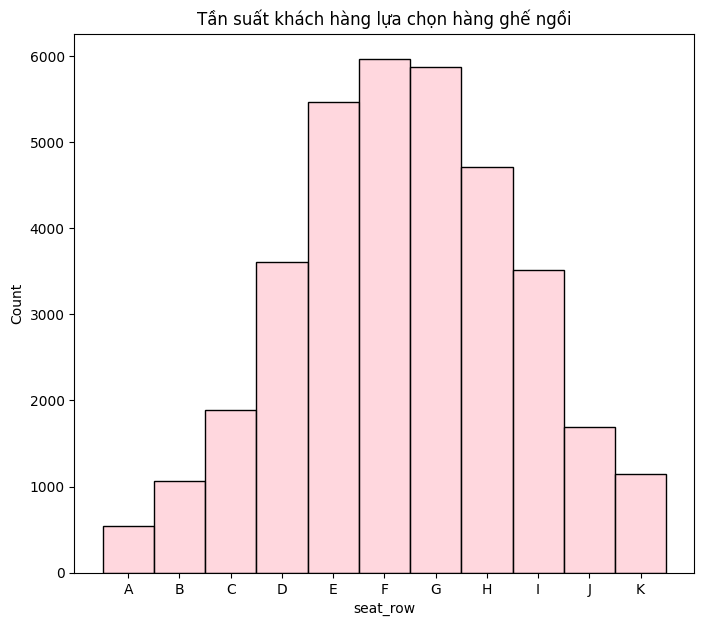

In [285]:
df_seat = df_tick.copy()
def extract_seatrow(data):
    return data[:1]

# extract seat_row
df_seat['seat_row'] = df_seat['slot'].apply(extract_seatrow)
df_seat = df_seat.sort_values(by='seat_row')

# plot seat_row histogram
fig, ax = plt.subplots(figsize=(8,7))
sns.histplot(data=df_seat, x='seat_row', color='#ffcad4')
plt.title('Tần suất khách hàng lựa chọn hàng ghế ngồi')
plt.show()

Phân tích:
- Mô tả: phần lớn khách hàng lựa chọn hàng ghế giữa từ D đến I
- Chẩn đoán: hàng ghế giữa thuận lợi để xem phim khi độ cao màn hình ngang tầm mắt
- Đề xuất: 
    + Tăng giá hàng ghế giữa
    + Giảm giá các hàng ghế thấp hoặc cao
    + Vào các đợt sắp ra mắt phim mới, hãy chủ động kết nối tới khách hàng và đề xuất các hàng ghế tốt như E F G
    + Tăng Cường Dịch vụ Hỗ Trợ Cho Hàng Ghế Cao và Thấp:Đảm bảo rằng khách hàng chọn hàng ghế ở các khu vực cao hoặc thấp vẫn nhận được trải nghiệm tốt. Cung cấp dịch vụ đặc biệt như gối, chăn, hoặc gói tiện ích đặc biệt để tối ưu hóa thoải mái. Hoặc tặng kèm nước uống hoặc quà tặng như móc khoá, ly nước, ...

Xếp hạng doanh thu theo khách hàng

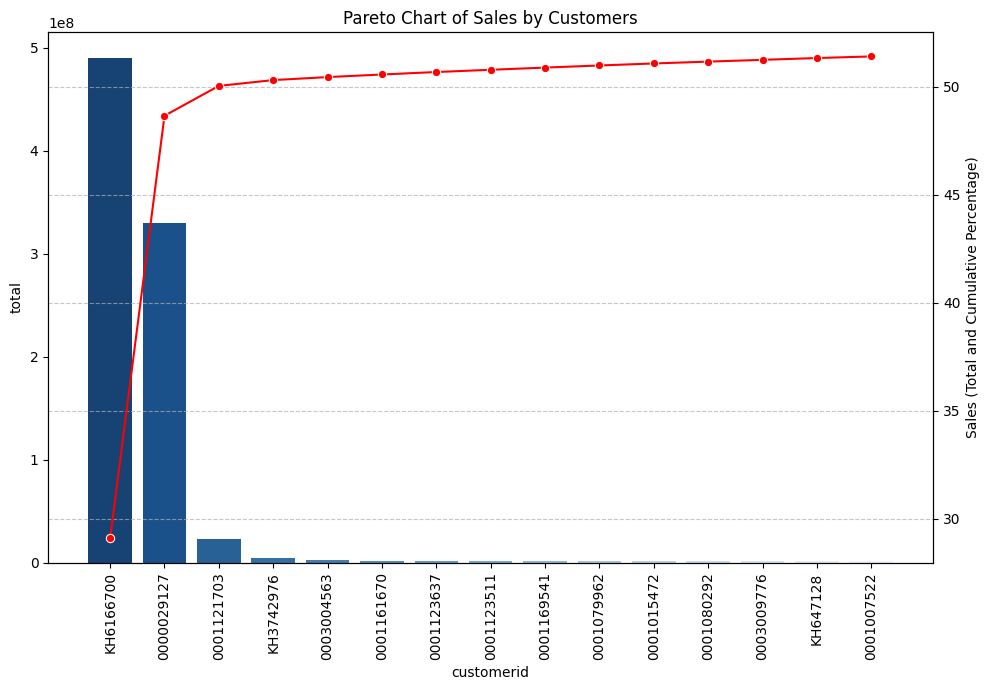

In [286]:
df_sale_cust = df_tick.drop_duplicates(subset=['orderid'])
df_sale_cust = pd.merge(df_sale_cust, df_cust, how='left', on='customerid')
df_sale_cust.head(3)

df_sale_cust = pd.DataFrame(df_sale_cust.groupby('customerid')['total'].sum()).reset_index().sort_values(by='total', ascending=False)

# # remove the 2 unsual customer
# df_sale_cust = df_sale_cust[2:]
# Calculate cumulative sum
df_sale_cust['cumulative_sum'] = df_sale_cust['total'].cumsum()

# Calculate total sum
total_sum = df_sale_cust['total'].sum()

# Calculate cumulative percentage
df_sale_cust['cumulative_percentage'] = (df_sale_cust['cumulative_sum'] / total_sum) * 100

# Select top
df_sale_cust = df_sale_cust.head(15)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1 = sns.barplot(data=df_sale_cust, x='customerid', y='total', palette='Blues_r')

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_sale_cust, x='customerid', y='cumulative_percentage', color='red', marker='o', linestyle='-')
plt.title('Pareto Chart of Sales by Customers')
plt.xlabel('Customers')
plt.ylabel('Sales (Total and Cumulative Percentage)')
# Rotate x-axis labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

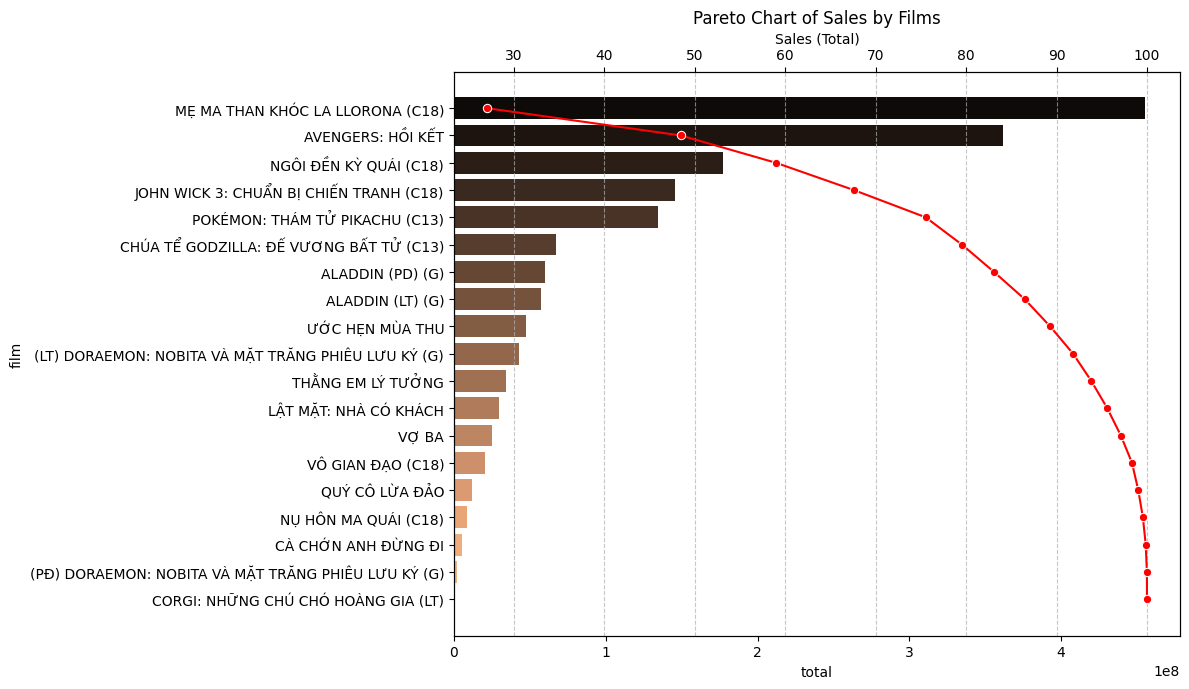

In [287]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_sale_cust = df_tick.drop_duplicates(subset=['orderid'])
df_sale_cust = pd.merge(df_sale_cust, df_cust, how='left', on='customerid')
df_sale_cust.head(3)

df_sale_cust = pd.DataFrame(df_sale_cust.groupby('film')['total'].sum()).reset_index().sort_values(by='total', ascending=False)

# # remove the 2 unsual customer
# df_sale_cust = df_sale_cust[2:]
# Calculate cumulative sum
df_sale_cust['cumulative_sum'] = df_sale_cust['total'].cumsum()

# Calculate total sum
total_sum = df_sale_cust['total'].sum()

# Calculate cumulative percentage
df_sale_cust['cumulative_percentage'] = (df_sale_cust['cumulative_sum'] / total_sum) * 100

# Your existing code

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1 = sns.barplot(data=df_sale_cust, y='film', x='total', palette='copper')  # Horizontal bar chart

ax2 = ax1.twiny()  # Creating a twin Axes sharing the y-axis
ax2 = sns.lineplot(data=df_sale_cust, x='cumulative_percentage', y='film', color='red', marker='o', linestyle='-')
plt.title('Pareto Chart of Sales by Films')
plt.xlabel('Sales (Total)')
plt.ylabel('Customers')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Xếp hạng doanh thu theo nghề nghiệp

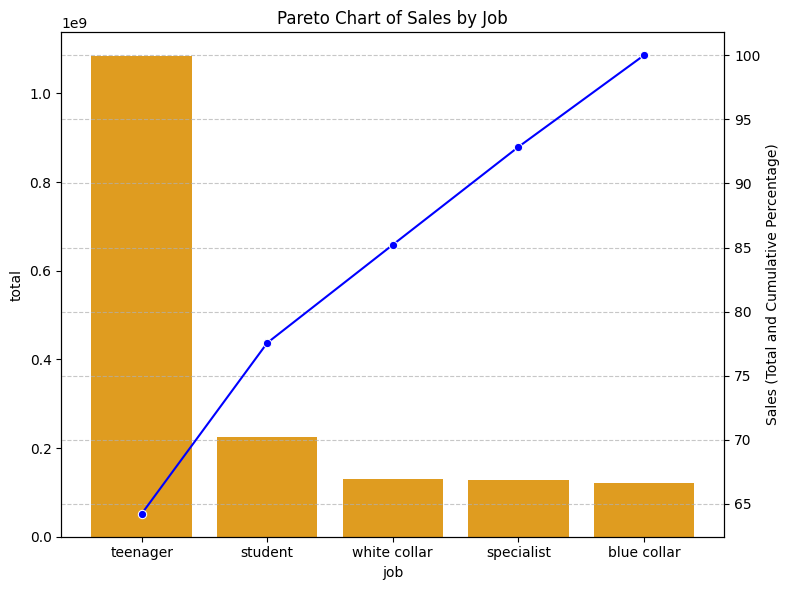

In [288]:
df_sale_job = df_tick.drop_duplicates(subset=['orderid'])
df_sale_job = pd.merge(df_sale_job, df_cust, how='left', on='customerid')
df_sale_job.head(3)

df_sale_job = pd.DataFrame(df_sale_job.groupby('job')['total'].sum()).reset_index().sort_values(by='total', ascending=False)

# # remove the 2 unsual customer
# df_sale_job = df_sale_job[2:]
# Calculate cumulative sum
df_sale_job['cumulative_sum'] = df_sale_job['total'].cumsum()

# Calculate total sum
total_sum = df_sale_job['total'].sum()

# Calculate cumulative percentage
df_sale_job['cumulative_percentage'] = (df_sale_job['cumulative_sum'] / total_sum) * 100

# Select top
df_sale_job = df_sale_job.head(10)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1 = sns.barplot(data=df_sale_job, x='job', y='total', color='orange')

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_sale_job, x='job', y='cumulative_percentage', color='blue', marker='o', linestyle='-')
plt.title('Pareto Chart of Sales by Job')
plt.xlabel('Jobs')
plt.ylabel('Sales (Total and Cumulative Percentage)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Xếp hạng khách hàng theo industry

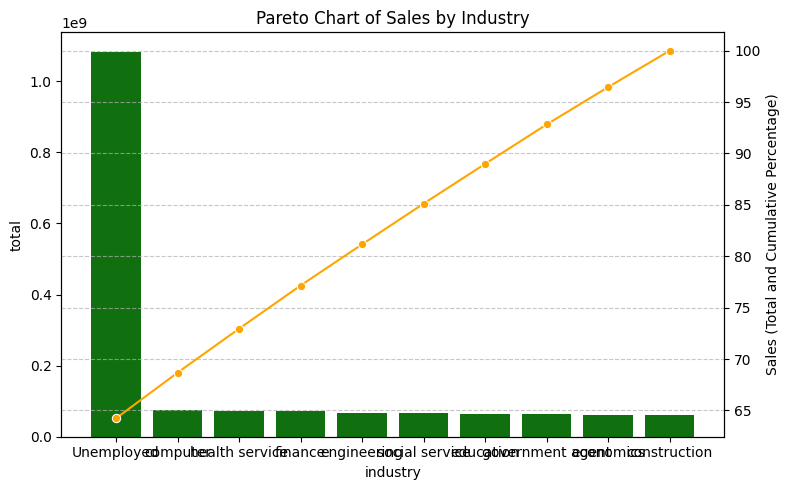

In [289]:
df_sale_industry = df_tick.drop_duplicates(subset=['orderid'])
df_sale_industry = pd.merge(df_sale_industry, df_cust, how='left', on='customerid')
df_sale_industry.head(3)

df_sale_industry = pd.DataFrame(df_sale_industry.groupby('industry')['total'].sum()).reset_index().sort_values(by='total', ascending=False)

# Calculate cumulative sum
df_sale_industry['cumulative_sum'] = df_sale_industry['total'].cumsum()

# Calculate total sum
total_sum = df_sale_industry['total'].sum()

# Calculate cumulative percentage
df_sale_industry['cumulative_percentage'] = (df_sale_industry['cumulative_sum'] / total_sum) * 100

# Select top
df_sale_industry = df_sale_industry.head(10)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1 = sns.barplot(data=df_sale_industry, x='industry', y='total', color='green')

ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_sale_industry, x='industry', y='cumulative_percentage', color='orange', marker='o', linestyle='-')
plt.title('Pareto Chart of Sales by Industry')
plt.xlabel('Jobs')
plt.ylabel('Sales (Total and Cumulative Percentage)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Phân tích khách hàng dựa trên số lần mua và tổng số tiền khách hàng đã chi


In [290]:
df_freq_cust = df_tick.copy()
# tính tổng tiền khách hàng đã chi theo suất chiếu
df_total_cust = df_freq_cust.groupby(['customerid', 'showtime']).agg(total_ticket_price=('ticket price', 'sum')).reset_index()
# result_df = grouped_df.size().reset_index(name='count')
# result_df
df_total_cust

# Số lần xem phim và tổng tiền vé đã mua
df_count_cust = df_total_cust.groupby('customerid').agg(total_ticket_price=('total_ticket_price', 'sum'),frequency_of_cust = ('customerid', 'count')).reset_index()
df_count_cust.sort_values(by='frequency_of_cust')

,customerid,total_ticket_price,frequency_of_cust
0,0000000014,90000,1
2602,0001136385,90000,1
2603,0001136403,90000,1
2604,0001136404,180000,1
2605,0001136405,90000,1
...,...,...,...
4008,0003009632,1035000,10
4397,KH7890071,1065000,11
2297,0001121703,23310000,102
642,0000029127,330210000,598


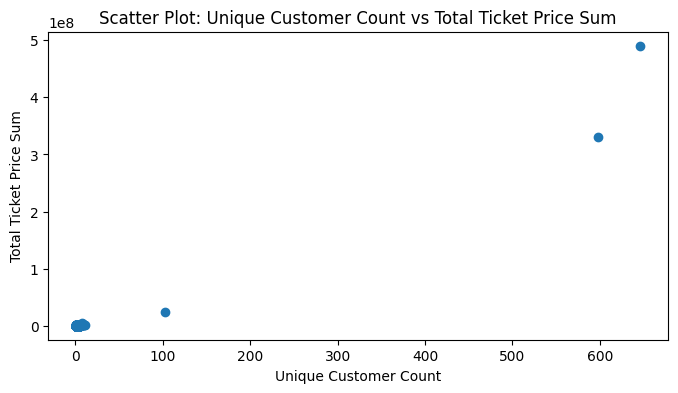

In [291]:
# Vẽ biểu đồ scatter
plt.figure(figsize=(8, 4)) 
plt.scatter(df_count_cust['frequency_of_cust'], df_count_cust['total_ticket_price'])

# Đặt tên trục và tiêu đề
plt.xlabel('Unique Customer Count')
plt.ylabel('Total Ticket Price Sum')
plt.title('Scatter Plot: Unique Customer Count vs Total Ticket Price Sum')

# Hiển thị biểu đồ
plt.show()

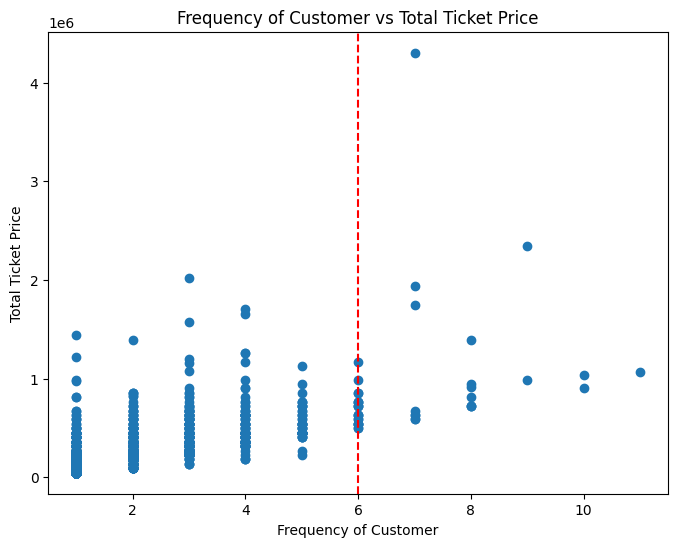

In [292]:
# Xóa các bản ghi có 'frequency_of_cust' lớn hơn 100
threshold_value = 100
df_sale_cust = df_count_cust[df_count_cust['frequency_of_cust'] <= threshold_value]

df_freq_cust = df_tick.copy()
# tính tổng tiền khách hàng đã chi theo suất chiếu
df_total_cust = df_freq_cust.groupby(['customerid', 'showtime']).agg(total_ticket_price=('ticket price', 'sum')).reset_index()
# result_df = grouped_df.size().reset_index(name='count')
# result_df
df_total_cust

# In DataFrame sau khi xóa
df_sale_cust.sort_values(by='total_ticket_price')

# Vẽ biểu đồ scatter sau khi xóa
plt.figure(figsize=(8,6)) 
plt.scatter(df_sale_cust['frequency_of_cust'], df_sale_cust['total_ticket_price'])

# Đặt tên trục và tiêu đề
plt.xlabel('Frequency of Customer')
plt.ylabel('Total Ticket Price')
plt.title('Frequency of Customer vs Total Ticket Price')

vertical_lines = [6]  # vị trí các ticks để vẽ các đường thẳng (theo thứ tự)
for line in vertical_lines:
    plt.axvline(x=line, color='red', linestyle='--')

# Hiển thị biểu đồ
plt.show()

- Phân tích:
    + Dựa vào biểu đồ trên ta dễ dàng thấy được rằng đa số khách hàng sẽ quay lại xem phim dưới 6 lần trong 1 tháng và số tiền chi trả cho việc xem phim dưới 1.000.000
    + Đặc biệt có những khách hàng quay lại xem phim 11 lần trong 1 tháng mà số tiền chi trả lại ít hơn khách hàng quay lại xem phim 7 lần trong 1 tháng


#### **Customer Analysis**

In [293]:
df_cust_copy = df_cust.copy()

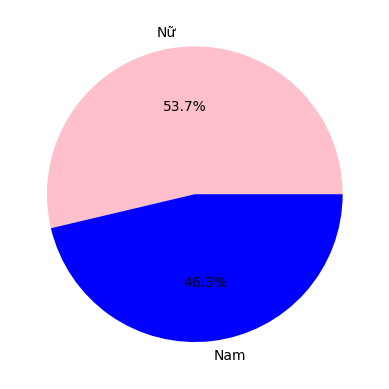

In [294]:
gender_ratio = pd.DataFrame((df_cust_copy['gender'].value_counts()/len(df_cust_copy))*100).reset_index(False)
plt.pie(gender_ratio['count'], labels=gender_ratio['gender'], autopct='%1.1f%%', colors=['pink','blue'])
plt.show()

- Khách hàng 53,7% nữ và 46,3% nam

In [295]:
# tính tuổi của từng khách
def age_calculate(data):
    present_date = datetime.now()
    # data = datetime.strptime(data, '%Y-%m-%d')
    age = present_date.year - data.year
    if present_date.month > data.month:
        return age
    elif present_date.month == data.month:
        if present_date.day >= data.day:
            return age
        else:
            age = age - 1
    else:
        return age -1
# tạo cột age 
df_cust_copy['Age'] = df_cust_copy['DOB'].apply(age_calculate)

Vẽ biểu đồ phân bố tuổi

In [296]:
# drop tuổi <0
list_drop = [482, 1177, 1563, 2207]
df_cust_copy = df_cust_copy.drop(list_drop)

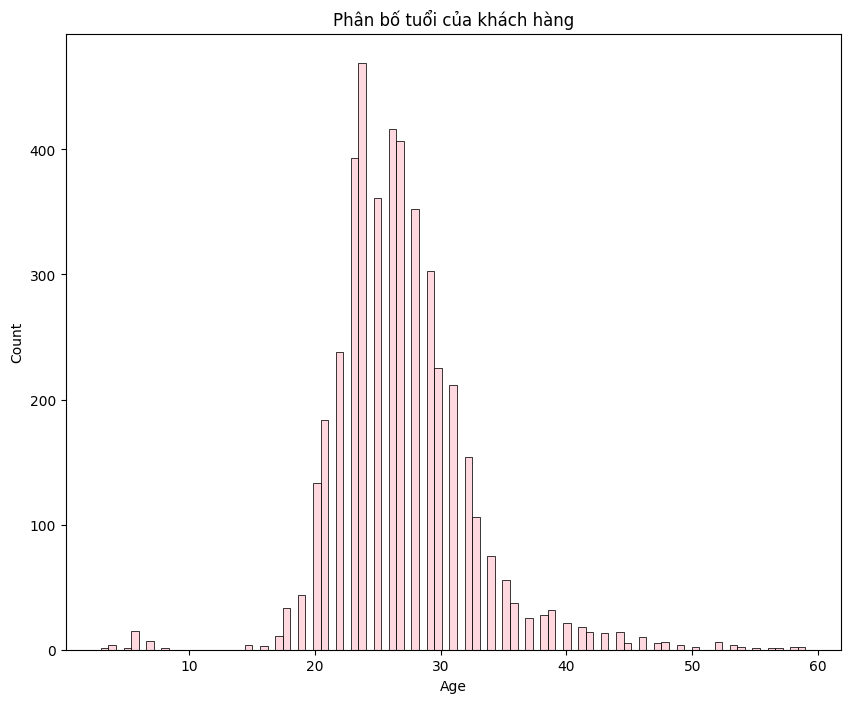

In [297]:
df_cust_copy = df_cust_copy.sort_values(by='Age')

# plot seat_row histogram
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df_cust_copy, x='Age', color='#ffcad4')
plt.title('Phân bố tuổi của khách hàng')
plt.show()

- Độ tuổi của khách hàng trải dài từ 5 đến 60 tuổi
- Từ 20 đến 35 tuổi là khoảng tập trung khách hàng nhiều nhất
- Độ tuổi đến rạp phim nhiều nhất vào tháng năm là 24 tuổi

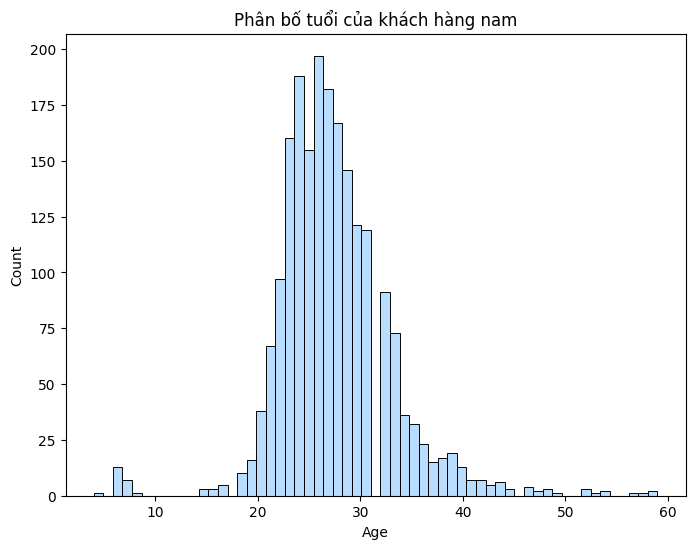

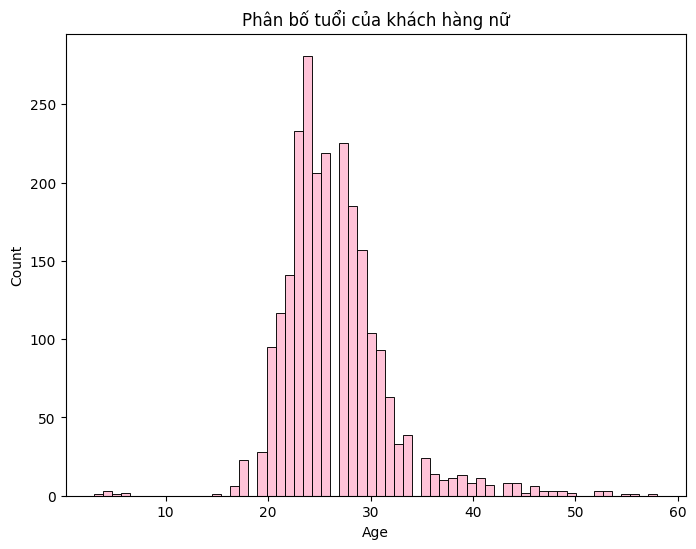

In [298]:
df_nam = df_cust_copy[df_cust_copy['gender'] == 'Nam']
df_nu = df_cust_copy[df_cust_copy['gender'] == 'Nữ']

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=df_nam, x='Age',color='#a2d2ff')
plt.title('Phân bố tuổi của khách hàng nam')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=df_nu, x='Age', color='#ffafcc')
plt.title('Phân bố tuổi của khách hàng nữ')
plt.show()

**Phân cụm khách hàng**

Số lượng record trước khi loại bỏ outlier 4479
Số lượng record sau khi loại bỏ outlier 4470


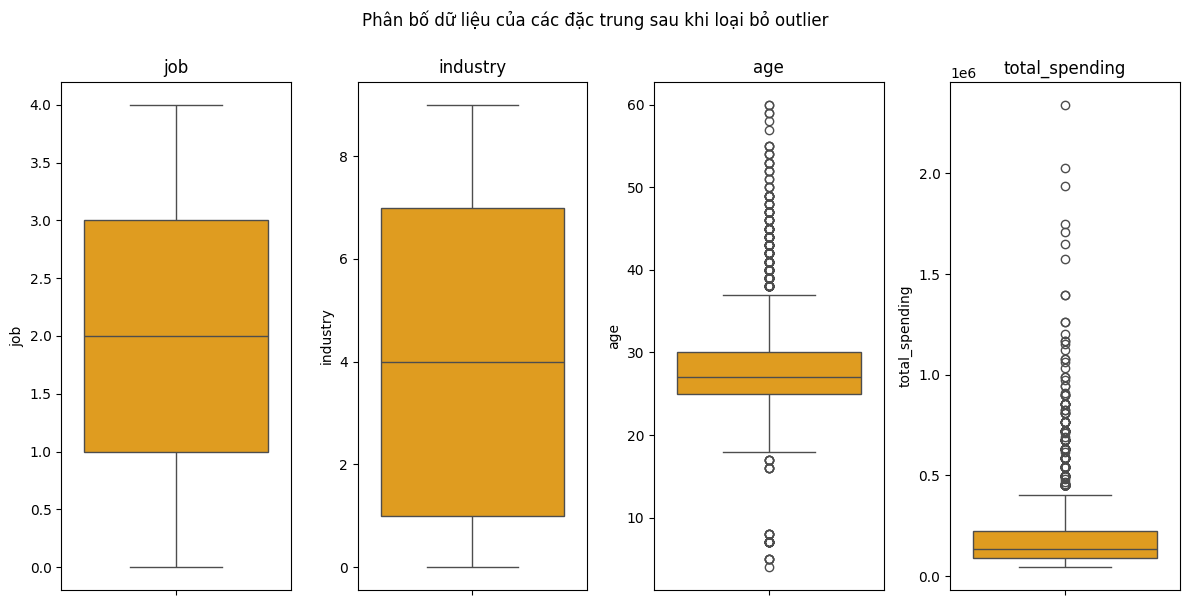

In [299]:
df_cluster = df_cust.copy()

# extract age
def extract_age(birthday):
    today = datetime.now().year
    age = today - birthday.year
    return age
df_cluster['age'] = df_cluster['DOB'].apply(extract_age)

# remove some columns
df_cluster = df_cluster.drop(columns=['Website','address','DOB'])

# remvove null
df_cluster = df_cluster.dropna()

# LabelEncoding
# list of categorical columns
list_categorical = ['gender', 'job', 'industry']
encoding_mappings = {}
for col in list_categorical:
    enc = LabelEncoder()
    df_cluster[col] = enc.fit_transform(df_cluster[col])
    encoding_mappings[col] = {index: label for label, index in enumerate(enc.classes_)}
# update encoding_mapping dictionary for decoding
for feature in encoding_mappings:
    encoding_mappings[feature] = {value: key for key, value in encoding_mappings[feature].items()}
encoding_mappings

# calculate spending
df_order = df_tick.drop_duplicates(subset=['orderid'])
# get total spending by customer
df_total_spending = pd.DataFrame(df_order.groupby('customerid')['total'].sum()).reset_index().rename(columns={'total':'total_spending'})
df_cluster = pd.merge(df_cluster, df_total_spending, how='left', on='customerid')
# get average spending by customer
df_average_spending = pd.DataFrame(df_order.groupby('customerid')['total'].mean()).reset_index().rename(columns={'total':'average_spending'})
df_cluster = pd.merge(df_cluster, df_average_spending, how='left', on='customerid')

# get number of transaction
df_freq = pd.DataFrame(df_order.drop_duplicates(subset=['customerid', 'showtime'])['customerid'].value_counts()).reset_index().rename(columns={'count':'number_of_transaction','index': 'customerid'})
df_cluster = pd.merge(df_cluster, df_freq, how='left', on='customerid')

# remove customerid
df_cluster = df_cluster.drop(columns='customerid')
print('Số lượng record trước khi loại bỏ outlier', len(df_cluster))
# remove outliers
df_cluster = df_cluster[(df_cluster['total_spending']<3e6) & (df_cluster['average_spending']<0.8e6)& (df_cluster['number_of_transaction']<20)]
#  
# df_cluster.to_csv('customer_cluster_2.csv', index=False)
print('Số lượng record sau khi loại bỏ outlier', len(df_cluster))
list_columns = ['job', 'industry', 'age', 'total_spending']
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs = axs.ravel()

for ind, col in enumerate(df_cluster[list_columns].columns):
    sns.boxplot(data=df_cluster, y=col, ax=axs[ind], color='orange')
    axs[ind].set_title(col)
    axs[ind].set_ylabel(col)  # Set y-axis label
    axs[ind].set_xlabel('')  # Optionally remove x-axis label

fig.suptitle('Phân bố dữ liệu của các đặc trung sau khi loại bỏ outlier', y=1)
plt.tight_layout()
plt.show()

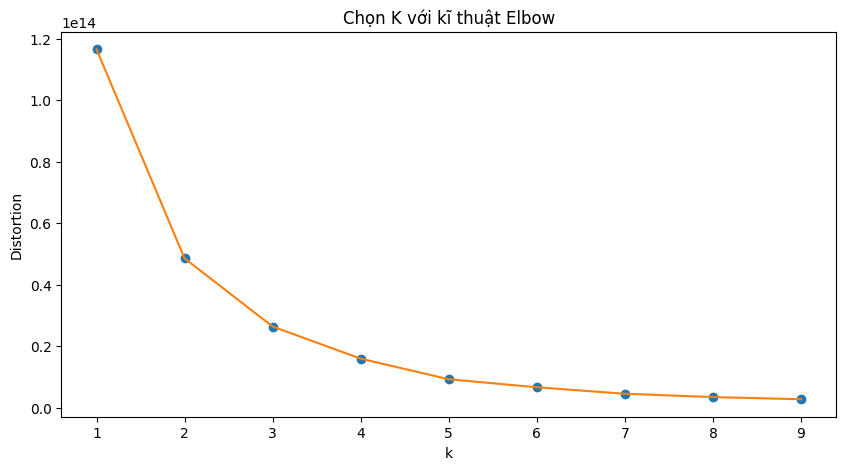

In [300]:
from sklearn.cluster import KMeans

# Choosing K with the elbow method
# Select features for clustering
list_columns_cluster = ['gender', 'job', 'industry', 'age', 'total_spending']
# , 'average_spending' , 'number_of_transaction'
X = df_cluster[list_columns_cluster]

K = range(1, 10)
distortions = []
for k in K:
    model = KMeans(n_clusters=k, init='k-means++', n_init=15, max_iter=350, random_state=42)
    model.fit(X)
    distortions.append(model.inertia_)

# Visualize result
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'o')
plt.plot(K, distortions, '-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Chọn K với kĩ thuật Elbow')
plt.show()

In [301]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Select features for clustering
list_columns_cluster = ['gender', 'job', 'industry', 'age', 'total_spending']
# , 'average_spending' , 'number_of_transaction'
X = df_cluster[list_columns_cluster]

# Scale data
scaler = MinMaxScaler()
X_encoded = scaler.fit_transform(X)

# Assuming you've chosen K based on the elbow method
chosen_k = 3  # Adjust this based on your elbow plot
# Train the KMeans model with the chosen K
model = KMeans(n_clusters=chosen_k, init='k-means++', n_init=15, max_iter=350, random_state=42)
model.fit(X_encoded)

# centroids = pd.DataFrame(model.cluster_centers_, columns=list_columns_cluster).transpose()

# Inverse transform the centroids with MinMaxScaler
centroids_original = scaler.inverse_transform(model.cluster_centers_)

# Create a DataFrame with the original centroids
centroids_df = pd.DataFrame(centroids_original, columns=list_columns_cluster).transpose()
centroids_df = round(centroids_df).astype(int)

# decoding
decode_columns = ['gender','job','industry']
for col in decode_columns:
    centroids_df.loc[col,:] = centroids_df.loc[col,:].map(encoding_mappings[col])
centroids_df

,0,1,2
gender,Nam,Nữ,Nữ
job,student,teenager,specialist
industry,education,computer,finance
age,28,25,30
total_spending,184290,200092,176135
